In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from typing import Tuple

import warnings
warnings.filterwarnings("ignore")

In [3]:
def simulateMarkovChain(initialState: Tuple, neighborsFunc, n = 100, onNewState = None):
    state = initialState
    if onNewState:
        onNewState(0,state)
    for i in range(1,n+1):
        neighborStates, neighborsProbabilities = neighborsFunc(state)
        sortedStateIndex = np.random.choice(range(len(neighborStates)), p = neighborsProbabilities)
        state = neighborStates[sortedStateIndex]
        if onNewState:
            onNewState(i,state)
    return state

# **Lattice**

In [4]:
def latticeNeighbors(state: Tuple, p = 0.5):
    neighbors = []
    probabilities = []
    i, j = state
    for neighbor in [(i-1,j),(i+1,j),(i,j-1),(i,j+1)]:
        i_neighbor, j_neighbor = neighbor
        if i_neighbor >= 1 and j_neighbor >= 1:
            neighbors.append(neighbor)
            if i_neighbor > i or j_neighbor > j:
                probabilities.append(p/2)
            else:
                probabilities.append((1-p)/2)
    selfLoopProbability = 1 - np.sum(probabilities)
    if selfLoopProbability > 0:
        neighbors.append((i,j))
        probabilities.append(selfLoopProbability)
    return neighbors, probabilities

In [13]:
def simulateLattice(initialState = (1,1), p = 0.5, n = 100, numSimulations = 1000, includeSubSamples = False):
    simulationData = []
    simulationColumns = ["simultationID", "simulationStep", "i","j"] if not includeSubSamples else ["simultationID","simulationStep", "i","j"]
    for i in tqdm(range(1,numSimulations+1)):
        sample = simulateMarkovChain(
            initialState,
            lambda state: latticeNeighbors(state, p), 
            n = n, 
            onNewState = None if not includeSubSamples else lambda step, state: simulationData.append([i,step,*state])
        )
        if not includeSubSamples:
            simulationData.append([i,n,*sample])
    simulationDF = pd.DataFrame(data = simulationData, columns = simulationColumns)
    return simulationDF

### **Estimation for $\pi_{(1,1)}$**

In [6]:
def estimateStationaryDistributionComponent(state, n = 1000, simulateFunc = None, **kwargs):
    simulationDF = simulateFunc(initialState = state, n = n, numSimulations = 1, includeSubSamples = True, **kwargs)
    simulationDF = simulationDF.set_index(["i","j"])[["simulationStep"]]
    simulationDF = simulationDF.loc[state]
    simulationDF = simulationDF.shift(-1).iloc[:-1] - simulationDF.iloc[:-1]
    if not simulationDF.empty:
        piState = 1/simulationDF.simulationStep.mean()
    else:
        piState = 0
    return piState

In [7]:
p_025, p_05, p_075 = 0.25, 0.5, 0.75
n = int(10e5)

In [ ]:
state = (1,1)
piState_p025 = estimateStationaryDistributionComponent(state, n = n, simulateFunc = simulateLattice, p = p_025)
print(f"pi{state} = {piState_p025:.5f}")

In [ ]:
state = (1,1)
piState_p05 = estimateStationaryDistributionComponent(state, n = n, simulateFunc = simulateLattice, p = p_05)
print(f"pi{state} = {piState_p05:.5f}")

In [ ]:
state = (1,1)
piState_p075 = estimateStationaryDistributionComponent(state, n = n, simulateFunc = simulateLattice, p = p_075)
print(f"pi{state} = {piState_p075:.5f}")

## **Manhattan Distance**

In [28]:
def latticeExpectedManhattanDistanceAtStepT(initialState = (1,1), stepT = 10, p = 0.25, samplesSize = 1000):
    initialState = np.array(initialState)
    dist = simulateLattice(
        initialState = initialState, 
        p = p, 
        n = stepT, 
        numSimulations = samplesSize, 
        includeSubSamples = False
    )[["i","j"]]
    dist["manhattan"] = dist.apply(
        lambda row: np.linalg.norm(np.array([row["i"], row["j"]]) - initialState, ord = 1), 
        axis = 1
    )
    manhattan = dist["manhattan"].mean()
    return manhattan

In [33]:
manhattan_t10_p025 = latticeExpectedManhattanDistanceAtStepT(stepT = 10, p = 0.25, samplesSize = 10000)
manhattan_t10_p050 = latticeExpectedManhattanDistanceAtStepT(stepT = 10, p = 0.50, samplesSize = 10000)
manhattan_t10_p075 = latticeExpectedManhattanDistanceAtStepT(stepT = 10, p = 0.75, samplesSize = 10000)
manhattan_t10_p025, manhattan_t10_p050, manhattan_t10_p075

100%|██████████| 10000/10000 [00:04<00:00, 2054.70it/s]


(0.8416, 2.6808, 5.812)

In [34]:
manhattan_t100_p025 = latticeExpectedManhattanDistanceAtStepT(stepT = 100, p = 0.25, samplesSize = 10000)
manhattan_t100_p050 = latticeExpectedManhattanDistanceAtStepT(stepT = 100, p = 0.50, samplesSize = 10000)
manhattan_t100_p075 = latticeExpectedManhattanDistanceAtStepT(stepT = 100, p = 0.75, samplesSize = 10000)
manhattan_t100_p025, manhattan_t100_p050, manhattan_t100_p075

100%|██████████| 10000/10000 [00:27<00:00, 358.75it/s]


(0.9982, 10.3713, 51.0501)

In [35]:
manhattan_t1000_p025 = latticeExpectedManhattanDistanceAtStepT(stepT = 1000, p = 0.25, samplesSize = 10000)
manhattan_t1000_p050 = latticeExpectedManhattanDistanceAtStepT(stepT = 1000, p = 0.50, samplesSize = 10000)
manhattan_t1000_p075 = latticeExpectedManhattanDistanceAtStepT(stepT = 1000, p = 0.75, samplesSize = 10000)
manhattan_t1000_p025, manhattan_t1000_p050, manhattan_t1000_p075

100%|██████████| 10000/10000 [04:43<00:00, 35.33it/s]


(0.9957, 34.7445, 501.5135)

## **Visualizing the Simulation Samples**

100%|██████████| 1000/1000 [00:26<00:00, 38.03it/s]


<AxesSubplot:xlabel='i', ylabel='j'>

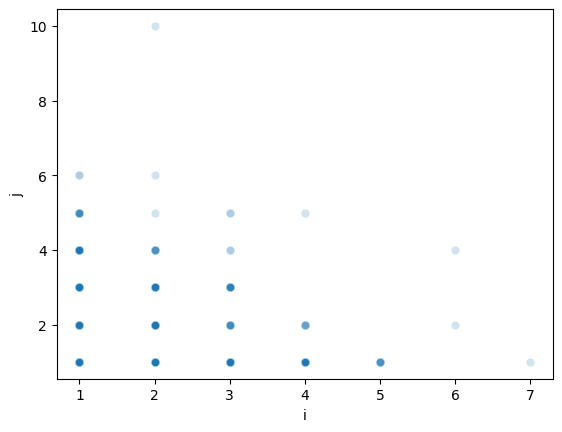

In [441]:
simulationDF = simulateLattice(initialState = (1,1), p = p_025, n = 1000, numSimulations = 1000, includeSubSamples = False)
sns.scatterplot(data = simulationDF, x = "i", y = "j", alpha = 0.2)

100%|██████████| 1000/1000 [00:26<00:00, 37.57it/s]


<AxesSubplot:xlabel='i', ylabel='j'>

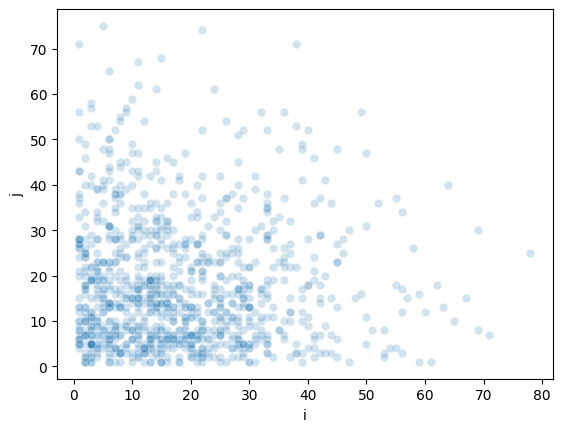

In [442]:
simulationDF = simulateLattice(initialState = (1,1), p = p_05, n = 1000, numSimulations = 1000, includeSubSamples = False)
sns.scatterplot(data = simulationDF, x = "i", y = "j", alpha = 0.2)

100%|██████████| 1000/1000 [00:25<00:00, 39.17it/s]


<AxesSubplot:xlabel='i', ylabel='j'>

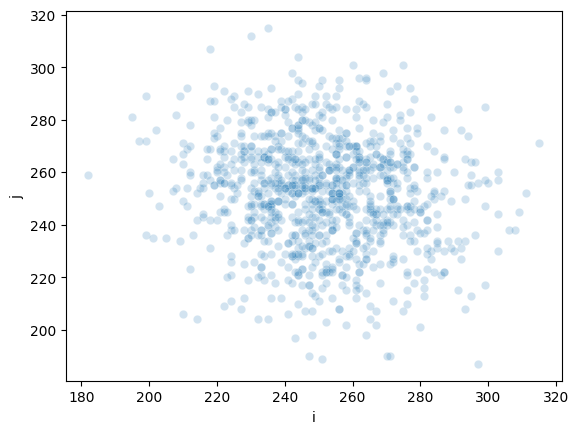

In [443]:
simulationDF = simulateLattice(initialState = (1,1), p = p_075, n = 1000, numSimulations = 1000, includeSubSamples = False)
sns.scatterplot(data = simulationDF, x = "i", y = "j", alpha = 0.2)